In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = (20, 5)

In [2]:
def get_rms(data, n):
    new = np.zeros(data.shape)
    for channel in range(data.shape[1]):
        for current in range(data.shape[0]):
            suma = 0
            for window in range(current, current - n, -1):
                suma += data[window, channel] * data[window, channel]
            new[current, channel] = (np.sqrt((1/n)*suma) / 128) if channel != 8 else data[current, channel]
    #plt.figure()
    #plt.plot(data)
    #plt.figure()
    #plt.plot(new)
    return new

def peel_labels(data):
    return data[:,:8], data[:,8]

def get_values(seshes, skip_hibernation):
    big_matrix = np.zeros((0, 9))
    for sesh in seshes:
        for gesture in range(8):
            wei = sesh + "/" + str(gesture) + ".txt"
            print(wei)
            matrix = np.genfromtxt(wei, delimiter=",")
            rms = get_rms(matrix, 80)
            #plt.figure()
            #plt.plot(rms)
            if skip_hibernation:
                rms = rms[rms[:,8] != 0]
                rms[:,8] -= 1
            #plt.figure()
            #plt.plot(rms)
            big_matrix = np.concatenate((big_matrix, rms), axis = 0)
    return big_matrix

In [3]:

#gotta go fast
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
print(*seshes, sep = "\n")
print("kekw")

start = 22

train_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation), \
                                 get_values([seshes[start + 1]], skip_hibernation), \
                                 get_values([seshes[start + 2]], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)


../myo-readings-dataset/_readings/03
../myo-readings-dataset/_readings/AM-S1
../myo-readings-dataset/_readings/AM-S2
../myo-readings-dataset/_readings/AM-S3
../myo-readings-dataset/_readings/Meritve seja 1
../myo-readings-dataset/_readings/Meritve seja 2
../myo-readings-dataset/_readings/Meritve seja 3
../myo-readings-dataset/_readings/Meritve-seja-1
../myo-readings-dataset/_readings/Meritve-seja-2
../myo-readings-dataset/_readings/Meritve-seja-3
../myo-readings-dataset/_readings/mi-seja1
../myo-readings-dataset/_readings/mi-seja2
../myo-readings-dataset/_readings/mi-seja3
../myo-readings-dataset/_readings/myo_session1
../myo-readings-dataset/_readings/myo_session2
../myo-readings-dataset/_readings/myo_session3
../myo-readings-dataset/_readings/record_1
../myo-readings-dataset/_readings/record_2
../myo-readings-dataset/_readings/record_3
../myo-readings-dataset/_readings/s1
../myo-readings-dataset/_readings/s2
../myo-readings-dataset/_readings/s3
../myo-readings-dataset/_readings/Seja 

In [4]:
'''
#selected sessions
selection = [22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 53, 55, 57]
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
seshes = [seshes[i] for i in selection]
print(*seshes, sep = "\n")
print("kekw")
np.random.shuffle(seshes)

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)

train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#selected sessions\nselection = [22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 53, 55, 57]\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nseshes = [seshes[i] for i in selection]\nprint(*seshes, sep = "\n")\nprint("kekw")\nnp.random.shuffle(seshes)\n\nsiz = len(seshes)\nsplit1 = int(0.6 * siz)\nsplit2 = int(0.8 * siz)\n\ntrain_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation),                                  get_values(seshes[split1:split2], skip_hibernation),                                  get_values(seshes[split2:], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

In [5]:
'''
#all sessions
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
np.random.shuffle(seshes)
print(*seshes, sep = "\n")
print("kekw")

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)
train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#all sessions\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nnp.random.shuffle(seshes)\nprint(*seshes, sep = "\n")\nprint("kekw")\n\nsiz = len(seshes)\nsplit1 = int(0.6 * siz)\nsplit2 = int(0.8 * siz)\ntrain_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation),                                  get_values(seshes[split1:split2], skip_hibernation),                                  get_values(seshes[split2:], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

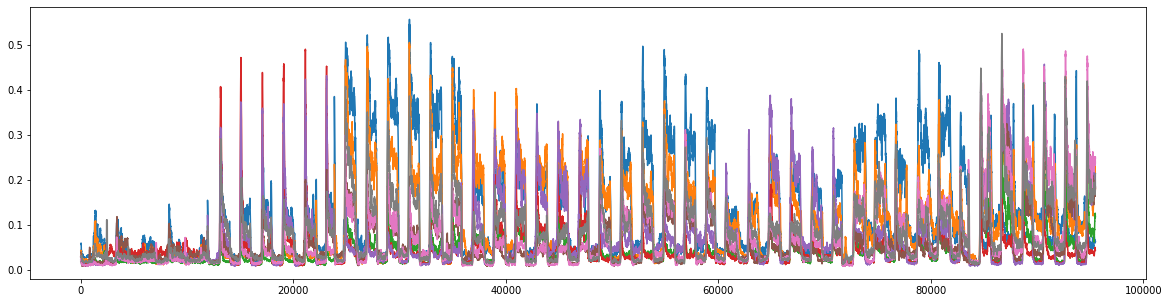

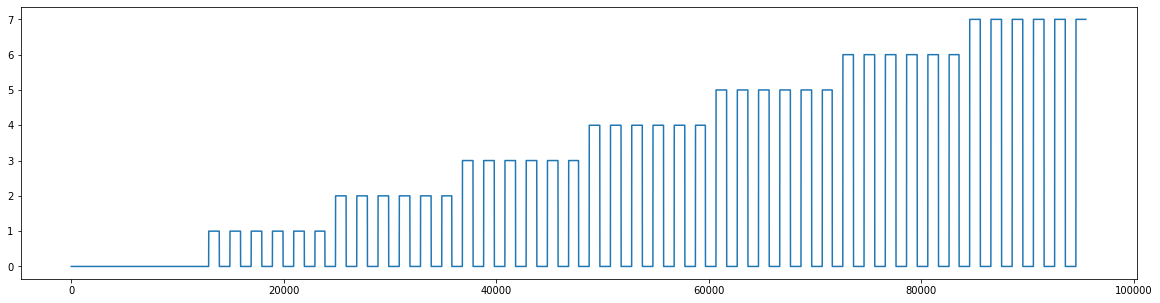

In [6]:
plt.figure()
plt.plot(train)
plt.figure()
plt.plot(train_labels)

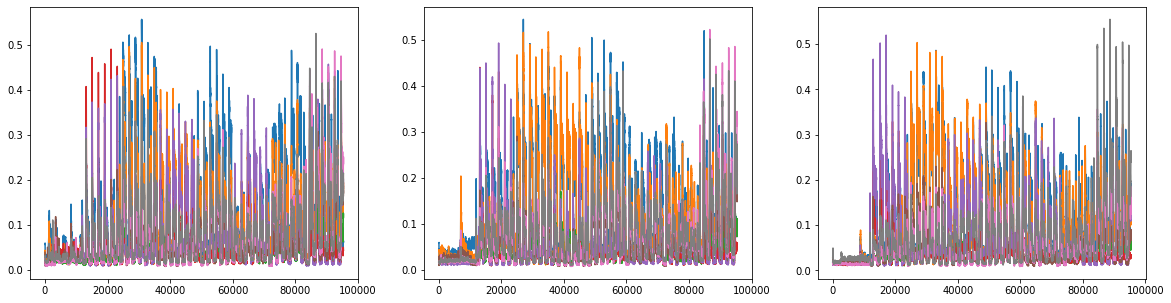

In [7]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train)
ax[1].plot(valid)
ax[2].plot(test)

In [8]:
model = keras.Sequential([
    keras.layers.Dense(200, activation = "relu", input_shape = (8,)),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(70, activation = "relu"),
    keras.layers.Dense(7 if skip_hibernation else 8, activation = "sigmoid")
])

opt = keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

In [9]:
model_checkpoint = ModelCheckpoint("weights.h5", save_best_only = True, save_weights_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model.fit(train, train_labels, 
                    validation_data = (valid, valid_labels), 
                    epochs = 20, 
                    callbacks = [early_stopping, model_checkpoint])
model.load_weights("weights.h5")

Epoch 1/20
2984/2984 [==============================] - 5s 2ms/step - loss: 0.5669 - accuracy: 0.8440 - val_loss: 0.6902 - val_accuracy: 0.7926
Epoch 2/20
2984/2984 [==============================] - 5s 2ms/step - loss: 0.2380 - accuracy: 0.9295 - val_loss: 0.7845 - val_accuracy: 0.7999
Epoch 3/20
2984/2984 [==============================] - 5s 2ms/step - loss: 0.2092 - accuracy: 0.9379 - val_loss: 0.9622 - val_accuracy: 0.7752
Epoch 4/20
2984/2984 [==============================] - 5s 2ms/step - loss: 0.1883 - accuracy: 0.9434 - val_loss: 1.1737 - val_accuracy: 0.7579
Epoch 5/20
2984/2984 [==============================] - 4s 1ms/step - loss: 0.1676 - accuracy: 0.9480 - val_loss: 1.1754 - val_accuracy: 0.7613
Epoch 6/20
2984/2984 [==============================] - 4s 1ms/step - loss: 0.1610 - accuracy: 0.9496 - val_loss: 1.3734 - val_accuracy: 0.7509


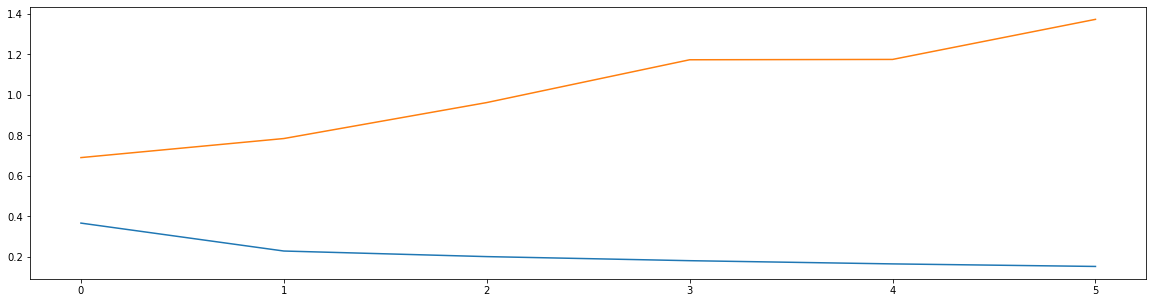

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

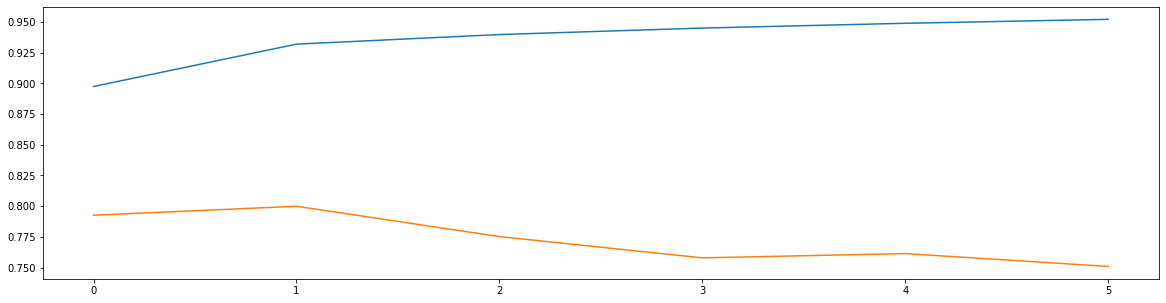

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [12]:
model.evaluate(test, test_labels)

2983/2983 [==============================] - 2s 587us/step - loss: 0.6487 - accuracy: 0.77720s - loss: 0.5216 - ac


[0.6486930847167969, 0.7772096991539001]

In [13]:
predictions = model.predict(test)

In [14]:
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels, normalize="pred")
conf

array([[7.91177164e-01, 8.23392975e-02, 7.53350235e-02, 1.91451862e-01,
        6.66430344e-02, 1.12097151e-01, 6.80713128e-02, 1.67810831e-02],
       [5.85043642e-03, 9.14512922e-01, 0.00000000e+00, 2.42344129e-03,
        0.00000000e+00, 3.42519072e-03, 0.00000000e+00, 0.00000000e+00],
       [5.20877565e-02, 0.00000000e+00, 9.24664976e-01, 0.00000000e+00,
        1.25841900e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.87536369e-03, 0.00000000e+00, 0.00000000e+00, 6.15333774e-01,
        0.00000000e+00, 5.91623852e-03, 0.00000000e+00, 0.00000000e+00],
       [1.91869152e-02, 2.98210736e-03, 0.00000000e+00, 0.00000000e+00,
        8.14073024e-01, 1.71259536e-03, 1.41004862e-01, 3.05110603e-03],
       [5.44153495e-03, 1.65672631e-04, 0.00000000e+00, 1.90790923e-01,
        0.00000000e+00, 6.00186829e-01, 0.00000000e+00, 0.00000000e+00],
       [5.44625305e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.83126551e-02, 2.57667757e-01, 7.90923825e-01, 0.

In [15]:
if skip_hibernation:
    legend = ["flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]
else:
    legend = ["hibernation", "flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]

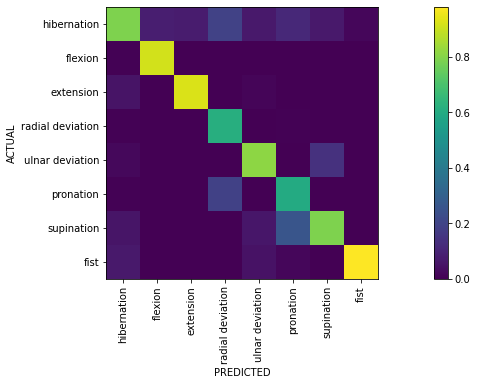

In [16]:
plt.imshow(conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(legend)), legend)
plt.xticks(np.arange(len(legend)), legend, rotation='vertical')
plt.colorbar()

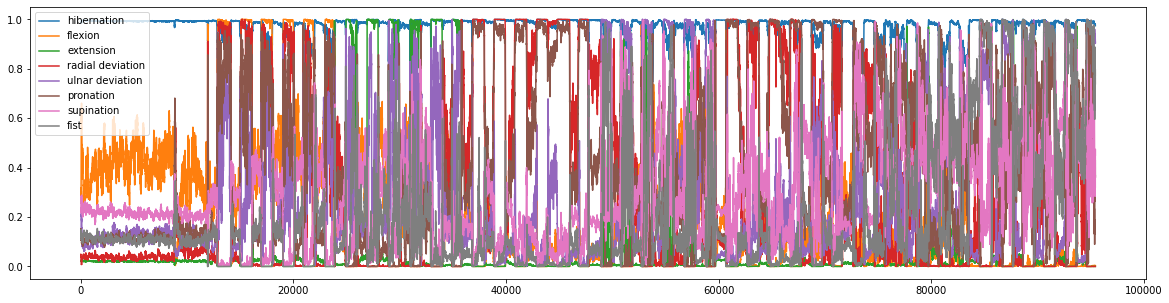

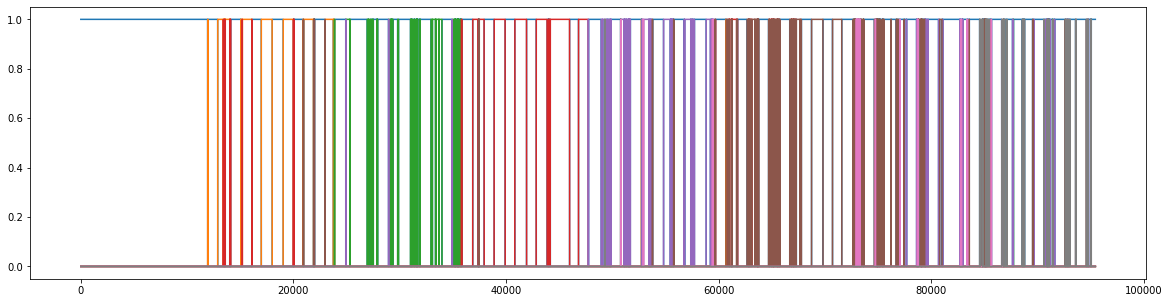

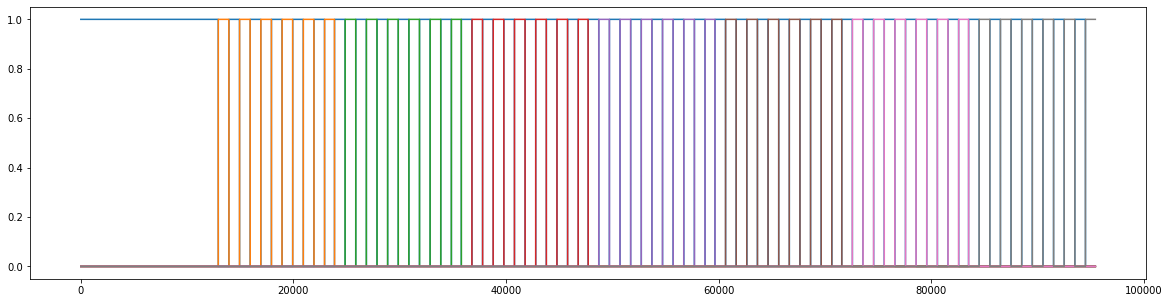

In [17]:
plt.figure()
plt.plot(predictions)
plt.legend(legend, loc = "upper left")

predicted_labels_onehot = keras.utils.to_categorical(predicted_labels, num_classes = 7 if skip_hibernation else 8)
test_labels_onehot = keras.utils.to_categorical(test_labels, num_classes = 7 if skip_hibernation else 8)

plt.figure()
plt.plot(predicted_labels_onehot)

plt.figure()
plt.plot(test_labels_onehot)

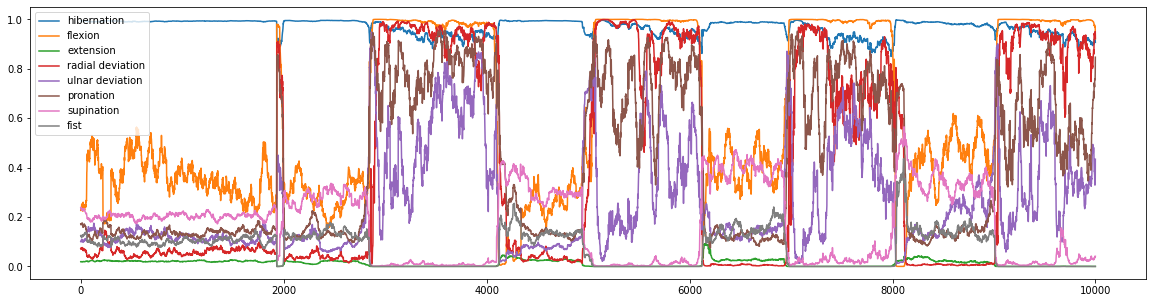

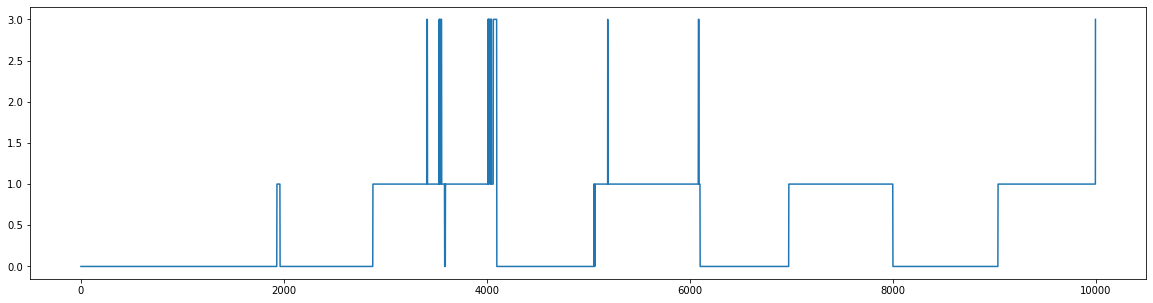

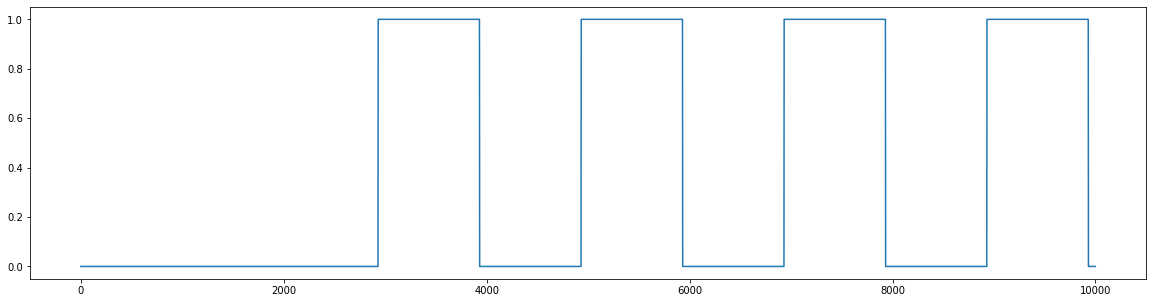

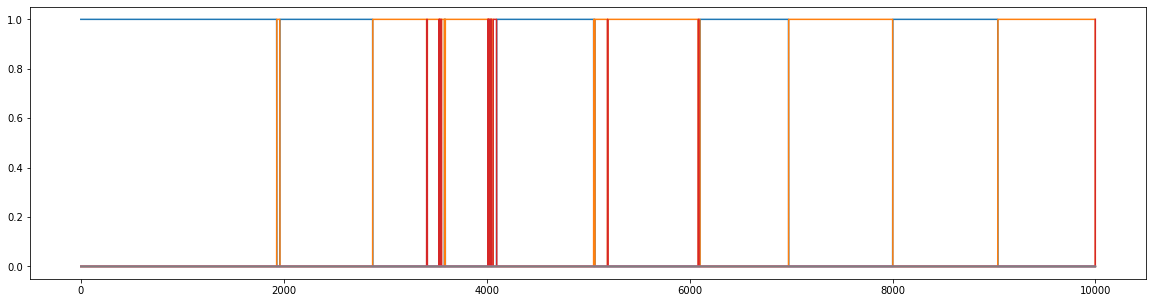

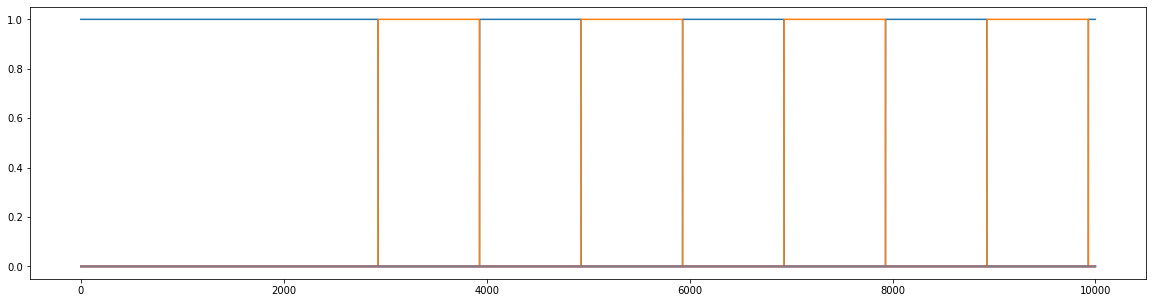

In [18]:
plt.figure()
plt.plot(predictions[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels[10000:20000])
plt.figure()
plt.plot(test_labels[10000:20000])
plt.figure()
plt.plot(predicted_labels_onehot[10000:20000])
plt.figure()
plt.plot(test_labels_onehot[10000:20000])

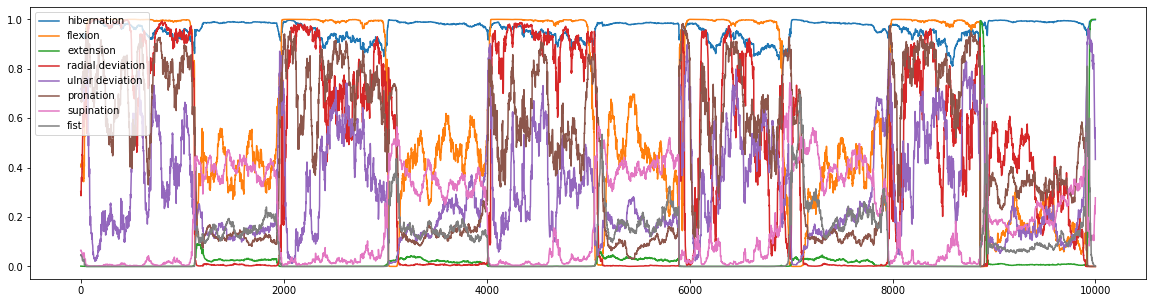

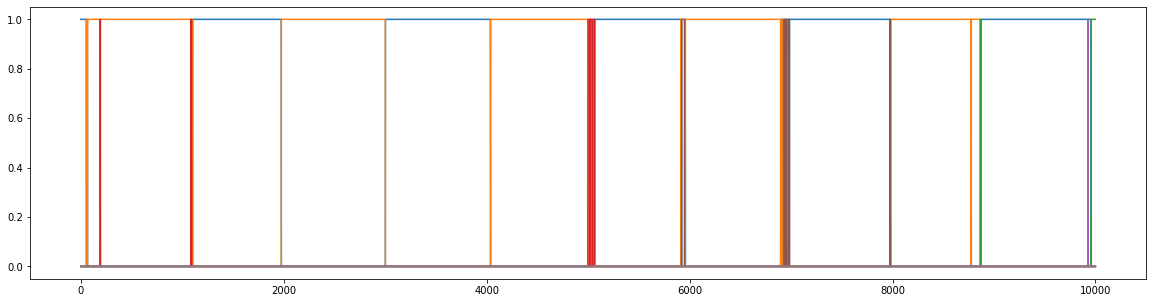

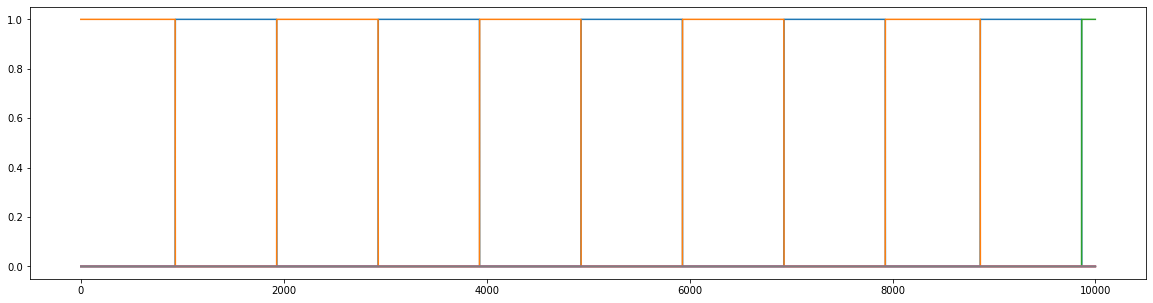

In [19]:
plt.figure()
plt.plot(predictions[15000:25000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels_onehot[15000:25000])
plt.figure()
plt.plot(test_labels_onehot[15000:25000])

In [20]:
training_analysis = model.predict(train)

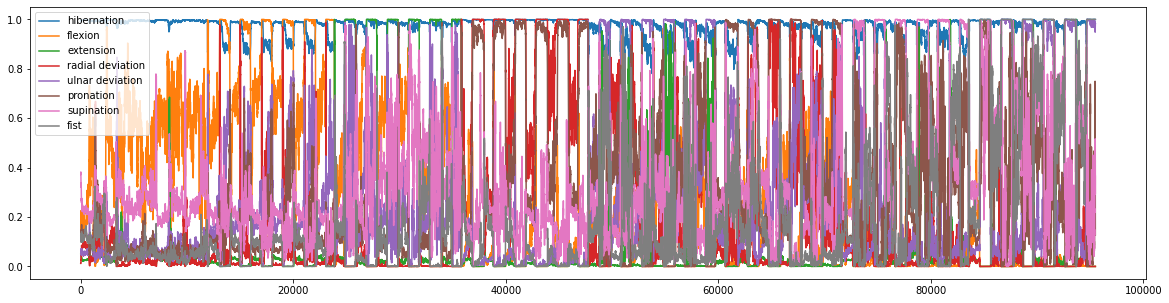

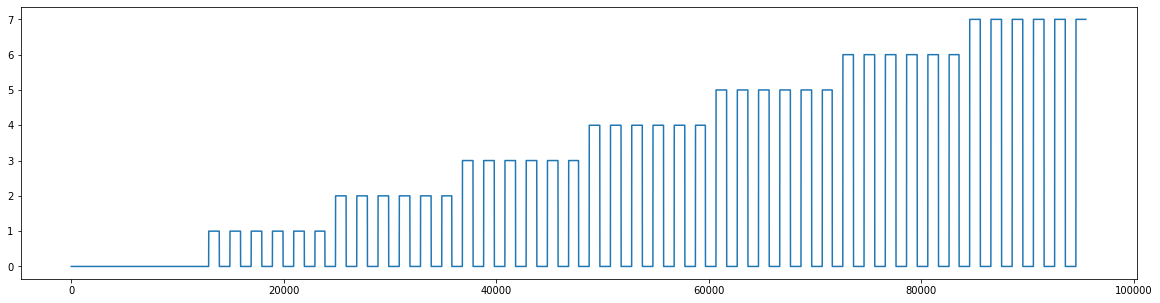

In [21]:
plt.figure()
plt.plot(training_analysis)
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels)

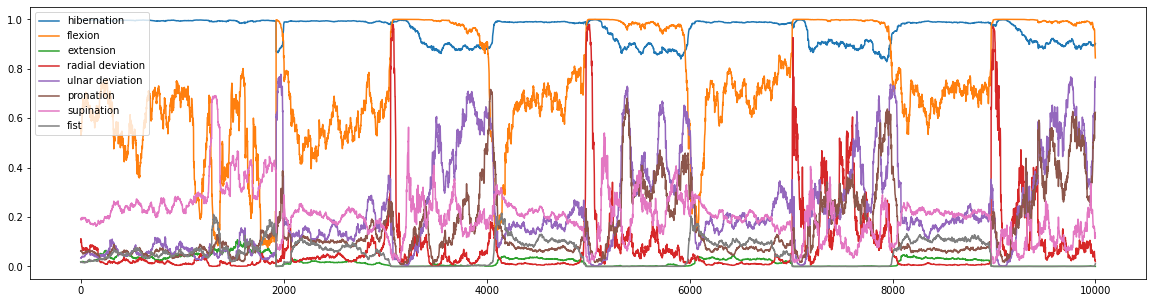

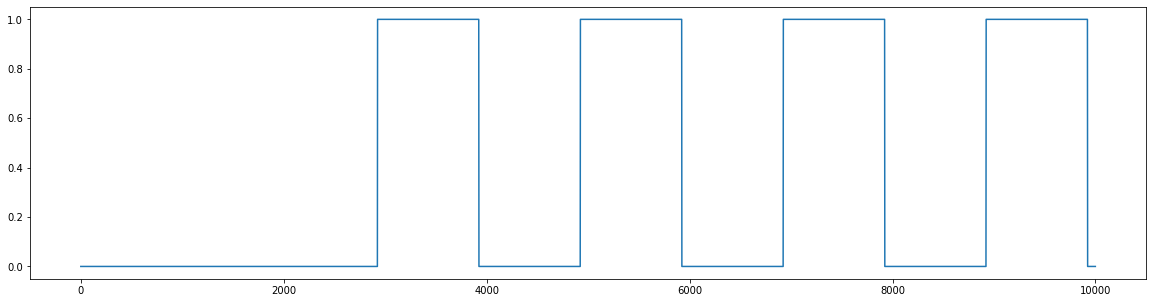

In [22]:
plt.figure()
plt.plot(training_analysis[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels[10000:20000])